In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# minus 부호 출력 설정
plt.rcParams['axes.unicode_minus'] = False  

In [3]:
data = pd.read_csv("datas/employee_salaries.csv")
display(data.head())
display(data.shape)

,Department,Department_Name,Division,Gender,Base_Salary,Overtime_Pay,Longevity_Pay,Grade
0,ABS,Alcohol Beverage Services,ABS 85 Administration,M,175873.000,0.00,0.0,M2
1,ABS,Alcohol Beverage Services,ABS 85 Administration,M,145613.360,0.00,0.0,M3
2,ABS,Alcohol Beverage Services,ABS 85 Administration,F,136970.000,0.00,0.0,M3
3,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,89432.694,0.00,2490.0,21
4,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,78947.000,456.68,6257.7,16


(10291, 8)

# Z-Score 직접 계산

Base_Salary 컬럼에 대한 Z-Score 계산하기

In [4]:
z = data.copy()

# 평균, 표준편차 계산
z_mean = z['Base_Salary'].mean()
z_std = z['Base_Salary'].std()

# Z-Score 계산하여 새로운 컬럼에 할당
z['z_Base_Salary'] = (z['Base_Salary'] - z_mean) / z_std


<Figure size 600x300 with 0 Axes>

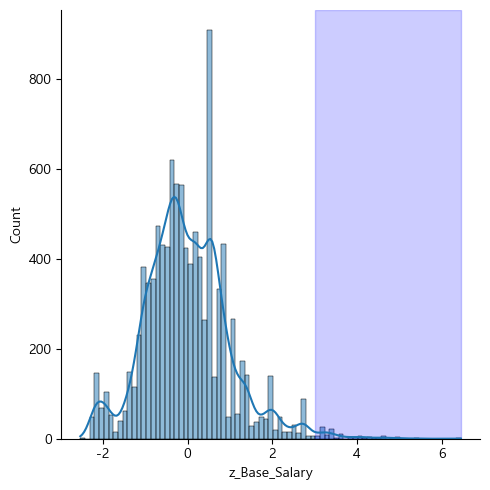

In [5]:
# Z-Score 시각화
plt.figure(figsize=(6, 3))
sns.displot(z['z_Base_Salary'], kde=True)
# alpha: 색상의 투명도를 조절(0: 투명, 1: 불투명)
plt.axvspan(xmin = 3, xmax= max(z['z_Base_Salary']), alpha=0.2, color='blue')
plt.show()

In [6]:
# 임계값 설정
threshold = 3

# 이상치가 아닌 값만 남기기
inlier = z[z['z_Base_Salary'].abs() <= threshold]
inlier = inlier.drop('z_Base_Salary', axis=1)

inlier.shape

(10183, 8)

# scipy.stats 라이브러리 활용하여 Z-Score 계산

In [7]:
from scipy import stats

z_scipy = data.copy()
z_scipy['z_Base_Salary'] = stats.zscore(z_scipy['Base_Salary'])

# 임계값 설정
threshold = 3

# 이상치가 아닌 값만 남기기
s_inlier = z_scipy[z_scipy['z_Base_Salary'].abs() <= threshold]
s_inlier = s_inlier.drop('z_Base_Salary', axis=1)
s_inlier.shape



(10183, 8)

# IQR 계산

In [8]:
Q1 = np.percentile(data['Base_Salary'], 25)
Q3 = np.percentile(data['Base_Salary'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

inlier = data[(data['Base_Salary'] >= lower_bound) & (data['Base_Salary'] <= upper_bound)]
inlier.shape

(10037, 8)

IQR로 이상치 제거 전과 후 boxplot으로 비교

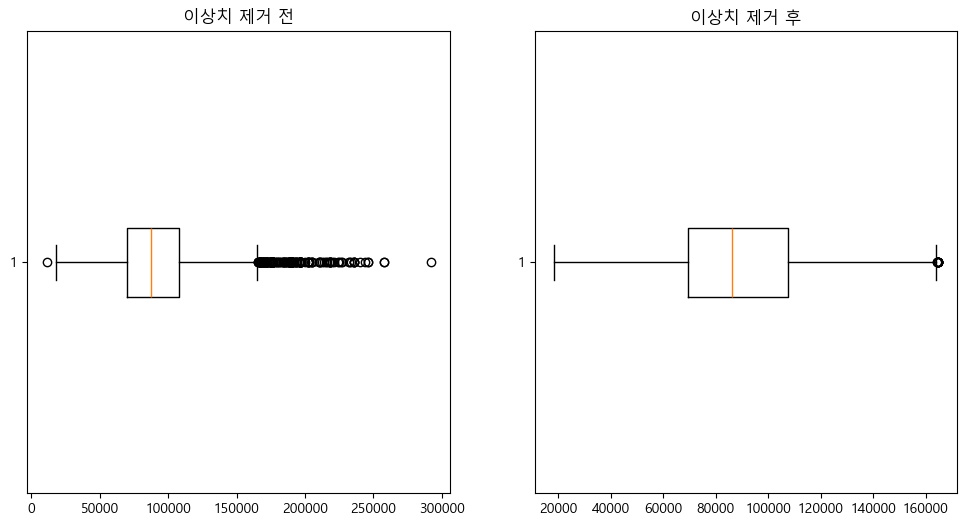

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# vert=False: 수평, vert=True: 수직
ax1.boxplot(data['Base_Salary'], vert=False)
ax1.set_title('이상치 제거 전')

ax2.boxplot(inlier['Base_Salary'], vert=False)
ax2.set_title('이상치 제거 후')

plt.show()

DBSCAN으로 이상치 제거

In [10]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

d = data.copy()
target_d = d[['Overtime_Pay', 'Longevity_Pay']]

# 표준화
scaler = StandardScaler()
scale_d = scaler.fit_transform(target_d)

# DBSCAN 클러스터링
db = DBSCAN(eps=0.5, min_samples=5).fit(scale_d)
labels = db.labels_

pd.Series(labels).value_counts()

 0    10247
-1       33
 1       11
Name: count, dtype: int64

In [11]:
clusters_sample = db.fit_predict(scale_d)
d['clusters'] = clusters_sample

inliers = d[d['clusters'] != -1]
inliers.shape

(10258, 9)

DBSCAN로 이상치 제거 후 산점도로 비교

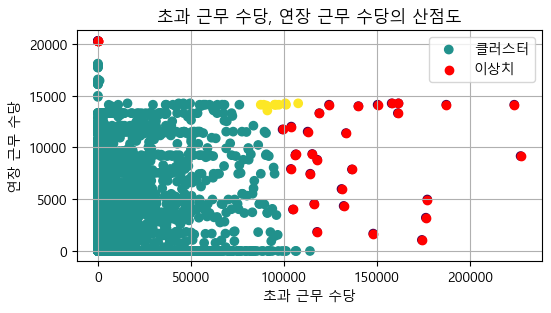

In [12]:
plt.figure(figsize=(6, 3))
# 원래 데이터
# c=d['clusters']: 점의 색상을 지정, 열의 값이 기준
plt.scatter(d['Overtime_Pay'], d['Longevity_Pay'], c=d['clusters'], label='클러스터')
# 이상치 데이터
plt.scatter(d[d['clusters'] == -1]['Overtime_Pay'], 
            d[d['clusters'] == -1]['Longevity_Pay'],
            color='red', label='이상치')

plt.title('초과 근무 수당, 연장 근무 수당의 산점도')
plt.xlabel('초과 근무 수당')
plt.ylabel('연장 근무 수당')
plt.legend()
plt.grid(True)
plt.show()

LOF로 이상치 제거

In [13]:
from sklearn.neighbors import LocalOutlierFactor

l = data.copy()
target_l = l[['Overtime_Pay', 'Longevity_Pay']].values

# 모델 생성
lof = LocalOutlierFactor(n_neighbors=50, contamination='auto')

# 이상치 탐지
labels = lof.fit_predict(target_l)
pd.Series(labels).value_counts()

 1    9873
-1     418
Name: count, dtype: int64

In [14]:
l['outliers'] = labels
inliers = l[l['outliers'] != -1]

len(inliers)

9873

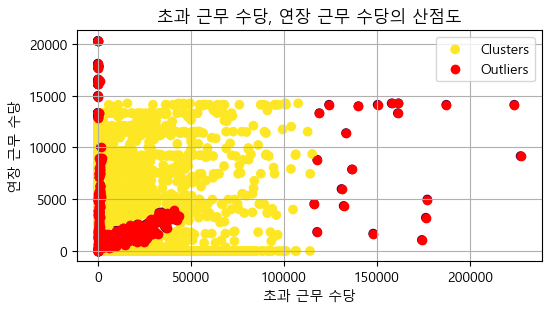

In [17]:
plt.figure(figsize=(6, 3))
plt.scatter(l['Overtime_Pay'], l['Longevity_Pay'], c=l['outliers'],  label='Clusters')
plt.scatter(l[l['outliers'] == -1]['Overtime_Pay'], 
            l[l['outliers'] == -1]['Longevity_Pay'], 
            color='red', label='Outliers')

plt.title('초과 근무 수당, 연장 근무 수당의 산점도')
plt.xlabel('초과 근무 수당')
plt.ylabel('연장 근무 수당')
plt.legend()
plt.grid(True)
plt.show()